# Implementation of Vanilla GANs model with Gaussian dataset
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torch.autograd as autograd

import numpy as np
import datetime
import os, sys
import random

import sklearn.datasets

random.seed(42)
np.random.seed(42)

from matplotlib.pyplot import imshow, imsave
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu")
DATASET = '25gaussians'
NO_OF_BATCHES = 100
BATCH_SIZE = 64
max_epoch = 100 # need more than 10 epochs for training generator
st = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 2

In [4]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=2, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, num_classes),
#             nn.ReLU(True),
#             nn.Linear(128, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y_ = self.layer(x)
        return y_

In [5]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=2, num_classes=2):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, num_classes),
#             nn.ReLU(True),
#             nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        return y_

In [6]:
def generate_image(dist):
    """
    Generates and saves a plot of the true distribution, the generator, and the
    critic.
    """
    for idx in range(NO_OF_BATCHES):
        plt.scatter(dist[idx][:,0], dist[idx][:,1], c='blue', marker='+')

    z = torch.randn(BATCH_SIZE*NO_OF_BATCHES, n_noise).to(DEVICE)
    z_outputs = G(z)
    
    z_outputs = z_outputs.cpu().detach().numpy()
    
    plt.scatter(z_outputs[:,0], z_outputs[:,1], c='red', marker='+')
    plt.show()

In [7]:
def inf_train_gen():
    if DATASET == '25gaussians':

        dataset = []
        for i in range(int(100000 / 25)):
            for x in range(-2, 3):
                for y in range(-2, 3):
                    point = np.random.randn(2) * 0.05
                    point[0] += 2 * x
                    point[1] += 2 * y
                    dataset.append(point)
        dataset = np.array(dataset, dtype='float32')
        np.random.shuffle(dataset)
        dataset /= 2.828  # stdev
        while True:
            for i in range(int(len(dataset) / BATCH_SIZE)):
                yield dataset[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

    elif DATASET == 'swissroll':

        while True:
            data = sklearn.datasets.make_swiss_roll(
                n_samples=BATCH_SIZE,
                noise=0.25
            )[0]
            data = data.astype('float32')[:, [0, 2]]
            data /= 7.5  # stdev plus a little
            yield data

    elif DATASET == '8gaussians':

        scale = 2.
        centers = [
            (1, 0),
            (-1, 0),
            (0, 1),
            (0, -1),
            (1. / np.sqrt(2), 1. / np.sqrt(2)),
            (1. / np.sqrt(2), -1. / np.sqrt(2)),
            (-1. / np.sqrt(2), 1. / np.sqrt(2)),
            (-1. / np.sqrt(2), -1. / np.sqrt(2))
        ]
        centers = [(scale * x, scale * y) for x, y in centers]
        while True:
            dataset = []
            for i in range(BATCH_SIZE):
                point = np.random.randn(2) * .02
                center = random.choice(centers)
                point[0] += center[0]
                point[1] += center[1]
                dataset.append(point)
            dataset = np.array(dataset, dtype='float32')
            dataset /= 1.414  # stdev
            yield dataset


In [8]:


D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
D_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(BATCH_SIZE, 1).to(DEVICE) # Discriminator Label to fake

data = inf_train_gen()

train = []

for _ in range(NO_OF_BATCHES):
    data_ = next(data)
    train.append(data_)

train = np.array(train)

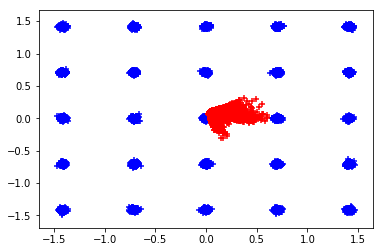

In [10]:
generate_image(train)

## Training time: ~420-430s

In [11]:
# from tensorboardX import SummaryWriter
# writer = SummaryWriter('runs')

In [12]:
def train_GAN(Gen, Disc):
    st = 0
    for epoch in range(1, max_epoch+1):
        for idx, x in enumerate(train):
            # Training Discriminator

            x = torch.Tensor(x)

            if DEVICE == torch.device("cuda"):
                x = x.cuda()

            x = torch.autograd.Variable(x)  
            x_outputs = Disc(x)      

            D_x_loss = criterion(x_outputs, D_labels)


            z = torch.randn(BATCH_SIZE, n_noise).to(DEVICE)
            z_outputs = Disc(Gen(z))
            D_z_loss = criterion(z_outputs, D_fakes)
            D_loss = D_x_loss + D_z_loss

            Disc.zero_grad()
            D_loss.backward()
            D_opt.step()

            if st % n_critic == 0:
                # Training Generator
                z = torch.randn(BATCH_SIZE, n_noise).to(DEVICE)
                z_outputs = Disc(Gen(z))
                G_loss = criterion(z_outputs, D_labels)

                Gen.zero_grad()
                G_loss.backward()
                G_opt.step()

    #         writer.add_scalar('Discriminator loss',D_loss.item(),idx)
    #         writer.add_scalar('Generator loss',G_loss.item(),idx)

            if st % 500 == 0:
                print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, st, D_loss.item(), G_loss.item()))
                #generate_image(train)
            st += 1

    print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, st, D_loss.item(), G_loss.item()))
    generate_image(train)
    # writer.export_scalars_to_json('./all_Scalars.json')
    # writer.close()

Epoch: 1/100, Step: 0, D Loss: 1.3756835460662842, G Loss: 0.6987336277961731


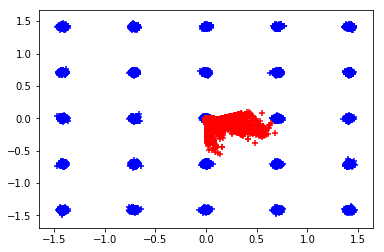

Epoch: 6/100, Step: 500, D Loss: 1.3961689472198486, G Loss: 0.7012092471122742


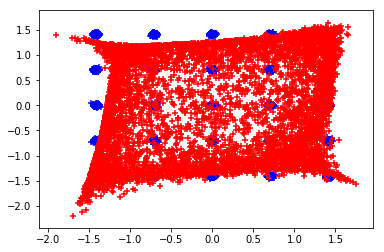

Epoch: 11/100, Step: 1000, D Loss: 1.3842368125915527, G Loss: 0.6997896432876587


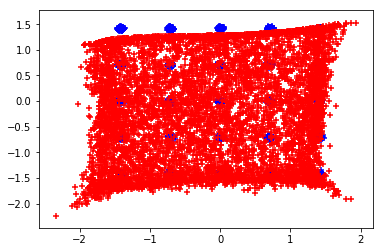

Epoch: 16/100, Step: 1500, D Loss: 1.3526856899261475, G Loss: 0.7202422618865967


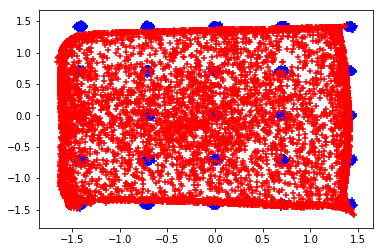

Epoch: 21/100, Step: 2000, D Loss: 1.3373463153839111, G Loss: 0.7406032085418701


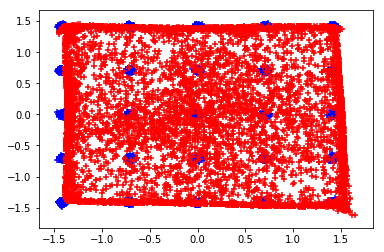

Epoch: 26/100, Step: 2500, D Loss: 1.2977910041809082, G Loss: 0.8255792856216431


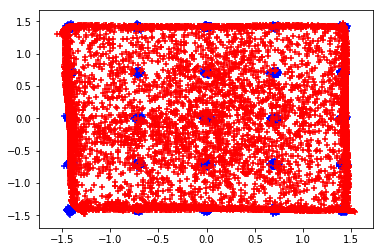

Epoch: 31/100, Step: 3000, D Loss: 1.160021185874939, G Loss: 0.972640335559845


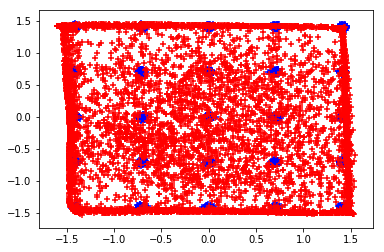

Epoch: 36/100, Step: 3500, D Loss: 1.0605010986328125, G Loss: 0.8511054515838623


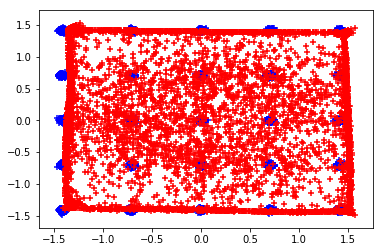

Epoch: 41/100, Step: 4000, D Loss: 1.0447330474853516, G Loss: 0.892539381980896


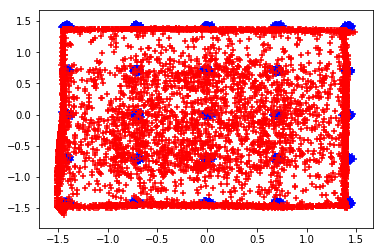

Epoch: 46/100, Step: 4500, D Loss: 0.9893006086349487, G Loss: 1.0724680423736572


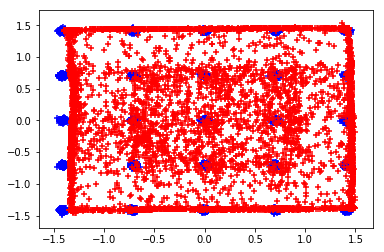

Epoch: 51/100, Step: 5000, D Loss: 0.9915087819099426, G Loss: 1.1251857280731201


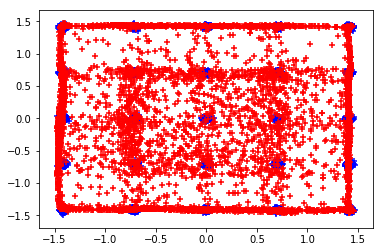

Epoch: 56/100, Step: 5500, D Loss: 1.0610544681549072, G Loss: 1.0783263444900513


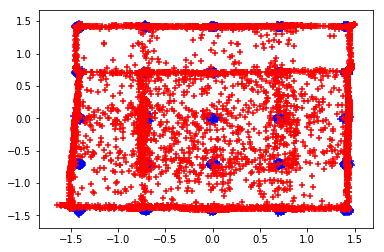

Epoch: 61/100, Step: 6000, D Loss: 1.0461194515228271, G Loss: 1.0945963859558105


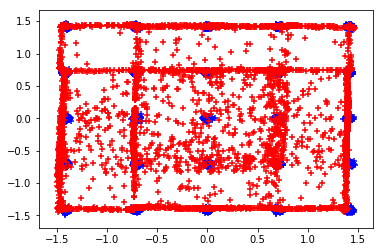

Epoch: 66/100, Step: 6500, D Loss: 1.1081589460372925, G Loss: 1.2803294658660889


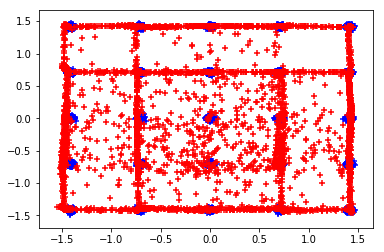

Epoch: 71/100, Step: 7000, D Loss: 1.0777919292449951, G Loss: 0.9802412390708923


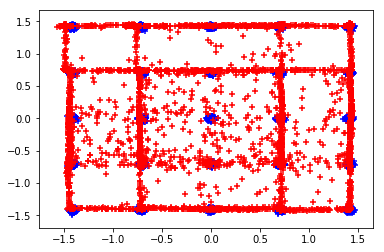

Epoch: 76/100, Step: 7500, D Loss: 1.085711121559143, G Loss: 0.9352844953536987


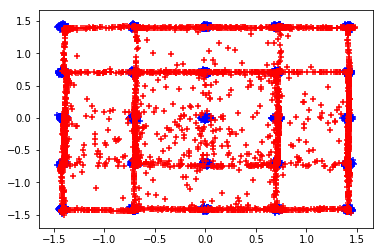

Epoch: 81/100, Step: 8000, D Loss: 1.1722559928894043, G Loss: 1.0776238441467285


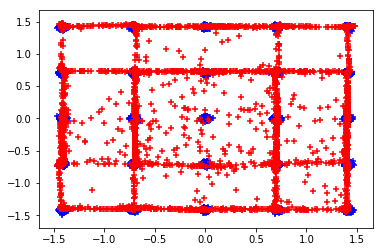

Epoch: 86/100, Step: 8500, D Loss: 1.039576530456543, G Loss: 1.118660569190979


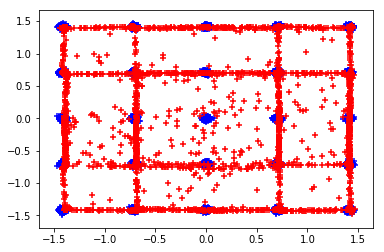

Epoch: 91/100, Step: 9000, D Loss: 1.1798776388168335, G Loss: 0.9524828195571899


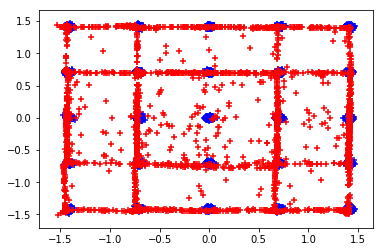

Epoch: 96/100, Step: 9500, D Loss: 1.0976845026016235, G Loss: 0.978362500667572


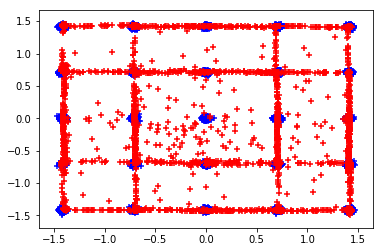

Epoch: 100/100, Step: 10000, D Loss: 1.0658230781555176, G Loss: 1.3399107456207275


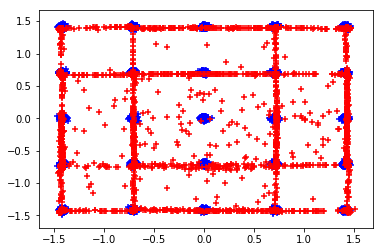

In [13]:
train_GAN(G,D)

In [14]:
# !tensorboard --logdir runs